In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import shutil
import cv2

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image

from tensorflow.keras.callbacks import Callback,EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, roc_auc_score

# Data Engineering

In [2]:
# check the numbers of images 
train_path='data/train_images/'
test_path='data/test_images/'

train_fns=sorted(glob(train_path+'*.jpg'))
test_fns=sorted(glob(test_path+'*.jpg'))

print('Numbers of train images=',len(train_fns))
print('Numbers of test images=',len(test_fns))


Numbers of train images= 12568
Numbers of test images= 5506


In [3]:
# check the image sizes

def get_image_sizes(path):
    
    widths=[]
    heights=[]
    images=sorted(glob(path+'*.jpg'))
    
    for im in range(len(images)):
        
        image=Image.open(images[im])
        w,h=image.size
        
        widths.append(w)
        heights.append(h)
        
    return max(widths),min(widths),max(heights),min(heights)

train_w_max, train_w_min, train_h_max, train_h_min=get_image_sizes(
    'data/train_images/')
test_w_max, test_w_min, test_h_max, test_h_min=get_image_sizes(
    'data/test_images/')

print('Max/Min widths & heights for train set: {}/{}, {}/{}'.format(
    train_w_max,train_w_min,train_h_max,train_h_min))
print('Max/Min widths & heights for test set: {}/{}, {}/{}'.format(
    test_w_max,test_w_min,test_h_max,test_h_min))



Max/Min widths & heights for train set: 1600/1600, 256/256
Max/Min widths & heights for test set: 1600/1600, 256/256


We can see all images have the same size.

In [4]:
# a peek into train.csv with defects info

train_df=pd.read_csv('data/train.csv')
print('The shape is',train_df.shape)
print('---------------------------------------------------------')
print('\nContents in csv file is like:')
print('=========================================================')
print(train_df.head(4))
print('\n---------------------------------------------------------')
print(train_df.info())

The shape is (7095, 3)
---------------------------------------------------------

Contents in csv file is like:
         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB
None


note that:

1) The filenames in train.csv only involves those with defects, i.e. it doesn't have all the images for training!

2) One line of info only concerns one type of defect. So for images with multiple types of defects, they would spread into multiple lines.

3) The last column of 'EncodedPixels' are the coordinates circling the locations of the defects. (see below for the end of this section (before 'Data Organzing') for example.)


In [5]:
# check the number of images with defects
num_image_defects=len(train_df.ImageId.unique())
num_image_no_defects=len(train_fns)-num_image_defects
print('# train images with defects:', num_image_defects,'/',len(train_fns))
print('# train images without defects:', num_image_no_defects,'/',len(train_fns))

# train images with defects: 6666 / 12568
# train images without defects: 5902 / 12568


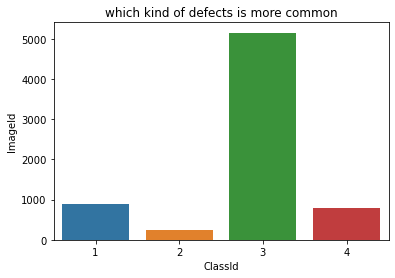

   ClassId  ImageId
0        1      897
1        2      247
2        3     5150
3        4      801


In [6]:
# analyse the type of defects
sns.barplot(
    data=train_df.groupby('ClassId').count().reset_index(),
    x='ClassId',
    y='ImageId')
plt.title('which kind of defects is more common')
plt.show()
print(train_df.groupby('ClassId').count().reset_index().iloc[:,:2])

We can see that type 3 defect is overwhemingly common.

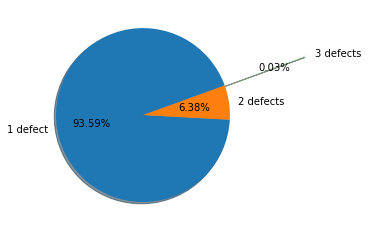

          ImageId
#defects         
1            6239
2             425
3               2


In [7]:
# analyse number of defects in one image

num_defects_one_image=train_df.groupby('ImageId')['ClassId'].count().reset_index()\
.rename(columns={'ClassId':'#defects'}).groupby('#defects').count()

# num_defects_one_image.plot.pie(y='ImageId',figsize=(5,5),
#                                autopct='%1.2f%%')
plt.pie(num_defects_one_image.ImageId,
        labels=['1 defect','2 defects','3 defects'],
        autopct='%1.2f%%',startangle=20,explode=(0,0,1),shadow=True)
plt.show()

print(num_defects_one_image)

It is the most common for images (out of the 12000 pictures) to have only one type of defect in them.

And no image have all four different types of defects.

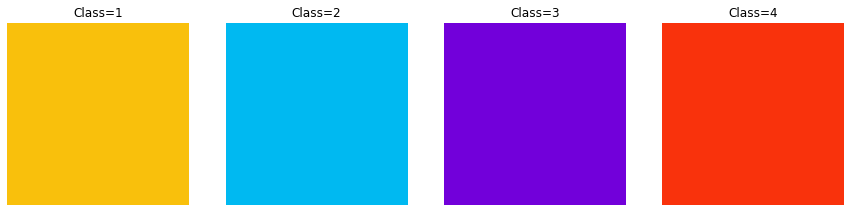

In [8]:
# assign the color for each class of defect for visualization

palet=[(249,192,12),
       (0,185,241),
       (114,0,218),
       (249,50,12)]

plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(np.ones((50,50,3),dtype=np.uint8)*palet[i])
    plt.axis('off')
    plt.title('Class='+str(i+1))
    
plt.show()

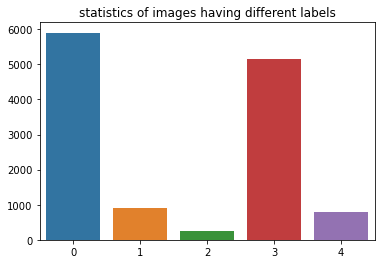

{'0': 5902, '1': 897, '2': 247, '3': 5150, '4': 801}


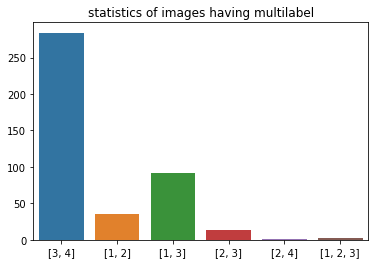

{'[3, 4]': 284, '[1, 2]': 35, '[1, 3]': 91, '[2, 3]': 14, '[2, 4]': 1, '[1, 2, 3]': 2}


In [9]:
train_flist=os.listdir(train_path)
train_df_flist=set(train_df['ImageId'])

image_no_defects=list(set(train_flist)-set(train_df_flist))
image_defects=train_df['ImageId'].unique().tolist()

#collect ind of images for each class of defect
images_class={} 
images_class['0']=image_no_defects
for i in range(1,5):
    images_class[str(i)]=[j for j in train_df.ImageId[
        train_df.ClassId==i]]

# collect # images having each class of defect
images_class_num={} 
images_class_num['0']=len(image_no_defects)
for i in range(1,5):
    images_class_num[str(i)]=(train_df.ClassId==i).sum()

sns.barplot(x=list(images_class_num.keys()),
            y=[images_class_num[i] for i in images_class_num])
plt.title('statistics of images having different labels')
plt.show()
print(images_class_num)
    
# collect info on images having multiple defects
images_multilabel={}
for i in image_defects:
    classid=train_df.ClassId[train_df.ImageId==i]
    if len(classid)>1:
        classid=str(classid.tolist())
        
        if classid in images_multilabel:
            images_multilabel[classid].append(i)
        else:
            images_multilabel[classid]=[i]

images_multilabel_num=images_multilabel.copy()
for i in images_multilabel_num:
    images_multilabel_num[i]=len(images_multilabel_num[i])
    
sns.barplot(x=list(images_multilabel_num.keys()),
            y=[images_multilabel_num[i] for i in images_multilabel_num])
plt.title('statistics of images having multilabel')
plt.show()
print(images_multilabel_num)

In [10]:
# auxiliary functions to convert the EncodedPixels of defect locations 
# into circulation ('mask') in pictures.


def name_to_mask(name): # 'name' means ImageId
    
    idx=train_df[train_df.ImageId==name].index.tolist()
    mask=np.zeros((256,1600,4),dtype=np.uint8) 
    # which matches the size of the images
    
    if idx==[]:
        return mask
    
    # convert the encoded pixels to mask
    for i in idx:
        classid=train_df.ClassId[i]
        mask_embedding=np.zeros(256*1600, dtype=np.uint8)
        
        rle=train_df.EncodedPixels[i].split(" ")
        
        positions=map(int,rle[0::2])
        length=map(int,rle[1::2])
        
        for pos, le in zip(positions,length):
            mask_embedding[(pos-1):(pos+le-1)]=1
        
        mask[:,:,classid-1]=mask_embedding.reshape(
            256,1600,order='F') # order by vertical direction first
        
    return mask

def show_mask_image(name):
    
    mask=name_to_mask(name)
    
    img=cv2.imread(str(train_path+'/'+name))
    
    fig,ax=plt.subplots(figsize=(15,15))
    
    for ch in range(4):
        contours, _=cv2.findContours(
            mask[:,:,ch],cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        for i in range(len(contours)):
            cv2.polylines(img,contours[i],True,palet[ch],2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()


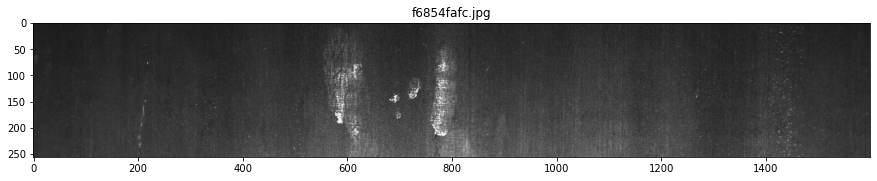

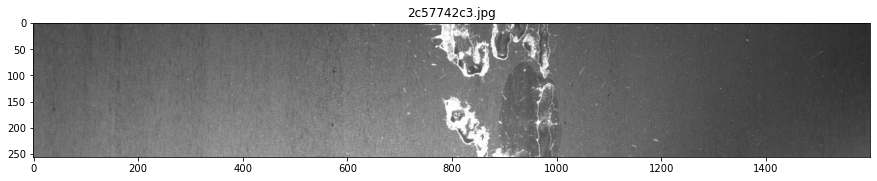

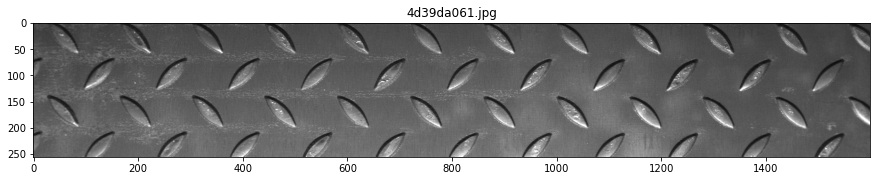

In [11]:
for name in images_class['0'][:3]:
    show_mask_image(name)

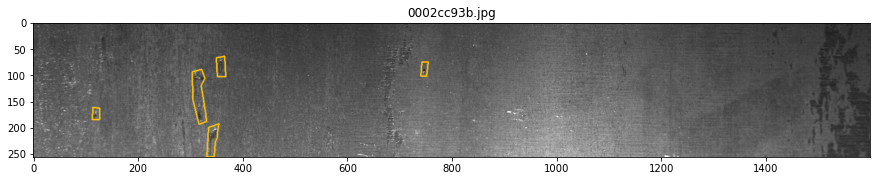

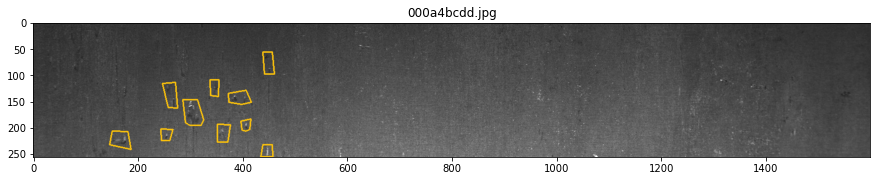

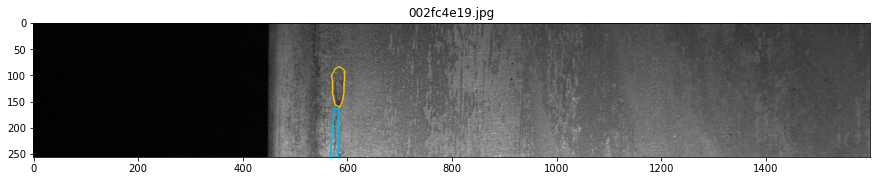

In [12]:
for name in images_class['1'][:3]:
    show_mask_image(name)

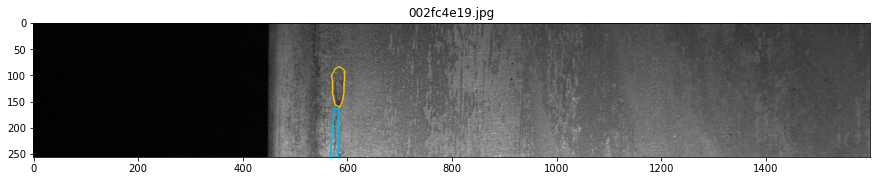

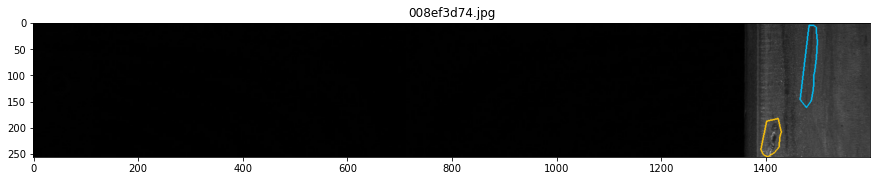

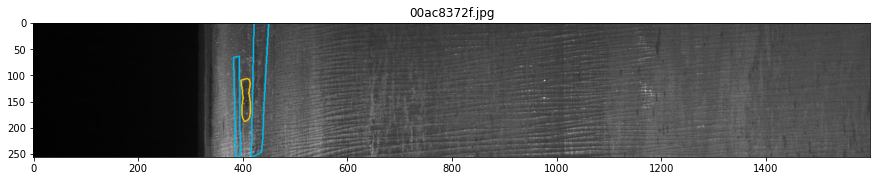

In [13]:
for name in images_class['2'][:3]:
    show_mask_image(name)

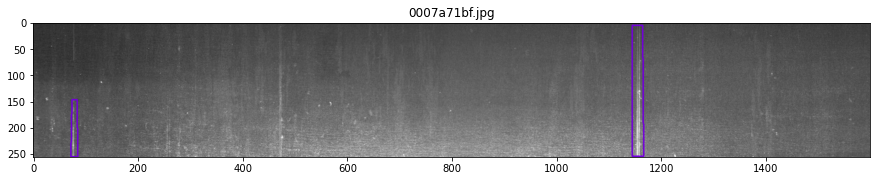

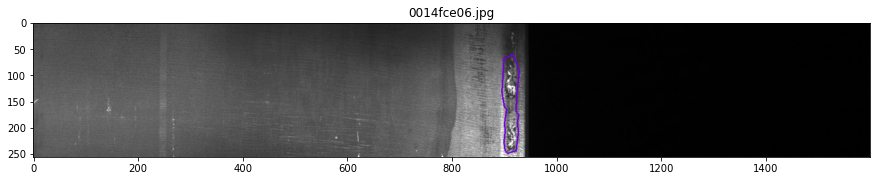

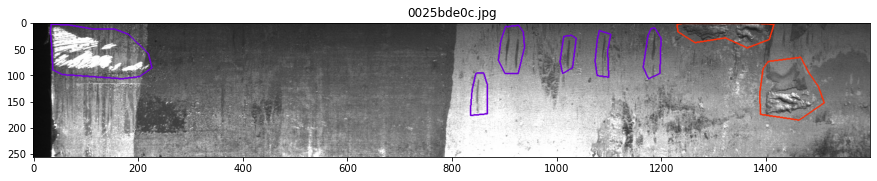

In [14]:
for name in images_class['3'][:3]:
    show_mask_image(name)

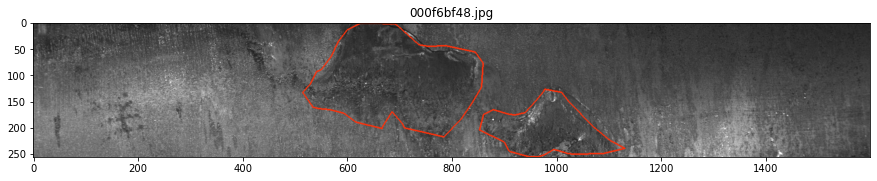

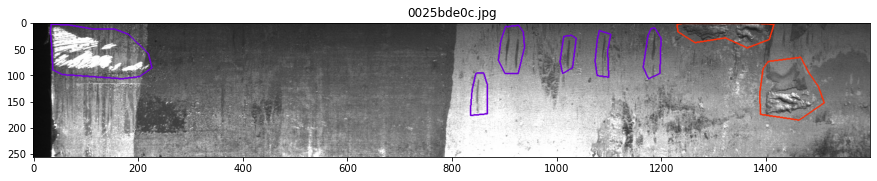

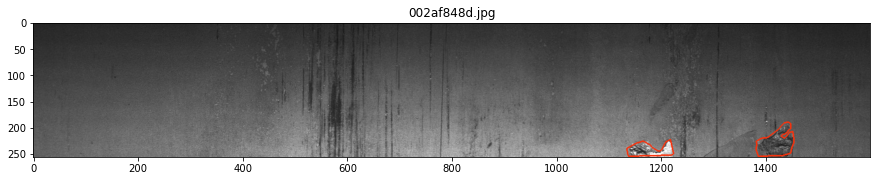

In [15]:
for name in images_class['4'][:3]:
    show_mask_image(name)

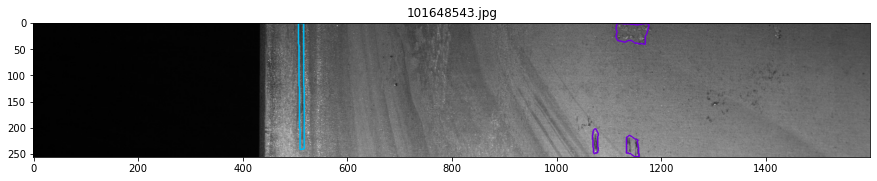

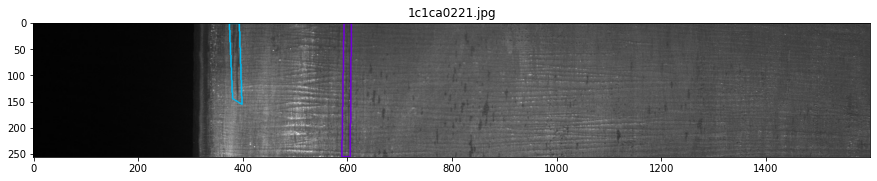

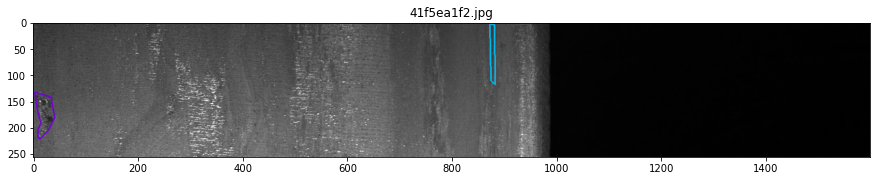

In [16]:
for name in images_multilabel['[2, 3]'][:3]:
    show_mask_image(name)

# Data Organizing

In [17]:
# see what is in the test csv 
# (gonna be involved in prediction)

submission_df=pd.read_csv('data/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(5506, 3)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [18]:
# create a dataframe containing the names of image files 
# needed for test

test_df=pd.DataFrame(submission_df['ImageId'].unique(),
                     columns=['ImageId'])
print(test_df.shape)
test_df.head()

(5506, 1)


,ImageId
0,0000f269f.jpg
1,000ccc2ac.jpg
2,002451917.jpg
3,003c5da97.jpg
4,0042e163f.jpg


From the shape of test_df, we can see the filenames in the sample_submission.csv are all unique.

In [19]:
# We will first determine if there are defects in the pictures
# before we try to do data segmentation to circle out the defects.

# So we try to group the images into those with defects 
# and those without defects here for the training in 
# the determination of the defect existence.


# dataframe for images containing labeled defects
# (they will be given a 'defect_label' of 1)
df_bin=pd.DataFrame(image_defects,columns=['ImageId'])
df_bin.loc[:,'defect_label']=1

# dataframe for images without labeled defects
# (they will be given a 'defect_label' of 0)
df_noDefect_bin=pd.DataFrame(image_no_defects,columns=['ImageId'])
df_noDefect_bin.loc[:,'defect_label']=0

# put together the dataframes with and without defects
df=pd.concat([df_bin, df_noDefect_bin]).reset_index(drop=True)
print(df.shape)
print()
print(df['defect_label'].value_counts())
df

# note images files in image_defects and image_no_defects are all training data
# (i.e. with known labels)

(12568, 2)

1    6666
0    5902
Name: defect_label, dtype: int64


,ImageId,defect_label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12563,02709b038.jpg,0
12564,c2514d9c0.jpg,0
12565,725d2e3da.jpg,0
12566,653bcd600.jpg,0


In [20]:
# Then images with defects would require data segmentation 
# to ciricle the defects (masking). We will use a U-net model for that.

# To train the U-net model, we will need another dataframe telling us 
# how many defects the images contain. 

mask_count_df=train_df.groupby('ImageId')['ClassId'].count().reset_index().rename(
    columns={'ClassId':'Num_ClassId'})
#count the number of defects in descending order
mask_count_df.sort_values('Num_ClassId',ascending=False,inplace=True)
mask_count_df.head()

,ImageId,Num_ClassId
6253,ef24da2ba.jpg,3
5740,db4867ee8.jpg,3
3435,84865746c.jpg,2
2203,5665ada1b.jpg,2
6149,eb44ad79d.jpg,2


### (1) Train/Val/Test split of dataset with known labels (for training the DesNet and VGG models to determine if the images contain defect or not)

In [21]:
num_images=df.shape[0]
df_train, df_test=train_test_split(
    df,test_size=0.2,stratify=df['defect_label'],random_state=2021)
df_train, df_val=train_test_split(
    df_train,test_size=0.25,stratify=df_train['defect_label'],random_state=2021)

In [22]:
# auxiliary functions for loading training/ validation/ test images
# will resize the images into a square size after loading them in

IMAGE_SIZE=224
# a function to be used in the function 'process_img'
def load_img(code,base,resize=True):
    path=f'{base}/{code}'
    img=cv2.imread(path)
    # convert to RGB for display
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    if resize:
        # rescale the image to the intended size
        img=cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
    return img

def validate_path(path):
    
    if os.path.exists(path):
        shutil.rmtree(path)
        
    os.makedirs(path)
        
train_tmp='0_organized_data/train'
validate_path(train_tmp)
val_tmp='0_organized_data/val'
validate_path(val_tmp)
test_tmp='0_organized_data/test'
validate_path(test_tmp)

def process_img(df,trainpath):
    
    # read img + resize and save
    
    for code in tqdm(df['ImageId']): 
        # tqdm is for making a progress status bar
        # to monitor the progress
        
        path=code.replace('.jpg','.png')
        
        if not os.path.exists(trainpath+'/'+path):
            img=load_img(code,base='data/train_images')
            cv2.imwrite(f'{trainpath}/{path}',img)
        
    df['ImageId']=df['ImageId'].apply(lambda x: x.replace('.jpg','.png'))
    
    return df

In [23]:
df_train=process_img(df_train,train_tmp)
df_val=process_img(df_val,val_tmp)
df_test=process_img(df_test,test_tmp) #note this test image is not the 'real test images' in the test folder

df_train.to_csv('0_organized_data/train/df_train.csv')
df_val.to_csv('0_organized_data/val/df_val.csv')
df_test.to_csv('0_organized_data/test/df_test.csv')

print(df_train.shape,df_val.shape,df_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 2514/2514 [00:17<00:00, 141.11it/s]

(7540, 2) (2514, 2) (2514, 2)



<ipython-input-22-4a4941703105>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ImageId']=df['ImageId'].apply(lambda x: x.replace('.jpg','.png'))


In [24]:
# see how many images have defects and how many do not
# in different sets
print(df_train['defect_label'].value_counts())
print(df_val['defect_label'].value_counts())
print(df_test['defect_label'].value_counts())


1    3999
0    3541
Name: defect_label, dtype: int64
1    1334
0    1180
Name: defect_label, dtype: int64
1    1333
0    1181
Name: defect_label, dtype: int64


### (2) Train/ Val split of training data for training the U-net model for image segmentation

In [25]:
mask_train_idx,mask_val_idx=train_test_split(
    mask_count_df.index, test_size=0.15, random_state=2021)

np.savez('0_organized_data/mask_train_val_split',mask_train_idx=mask_train_idx,
         mask_val_idx=mask_val_idx)